## Fine-Tuning Llama 3.2 1B Instruct 4-bit for Conflict Event Extraction 

The final stage shows how to fine-tune a **4-bit quantised Llama 3.2 1B Instruct** model using **LoRA**. The aim is to train it to extract structured data from ACLED conflict event texts. Each unstructured narrative is turned into a JSON object with **14 fields**, including the event date, location, actors, casualties, and other key details about the conflict.

### Workflow Overview  
1. Prepare and validate the ACLED dataset  
2. Configure LoRA adapters for the model  
3. Fine-tune the model with optimised training settings  
4. Evaluate performance using structured accuracy metrics and standard machine learning metrics (F1, Recall, etc.).  

This pipeline supports applications in automated conflict monitoring, research, and near real-time situational analysis.  

### Imports and Dependencies

These imports support all stages of the pipeline, including data preparation, quality scoring, model fine-tuning, and structured evaluation.

### Core Python Utilities  

- `os`, `Path`: File and directory operations  
- `re`, `json`: Pattern matching and JSON parsing  
- `random`, `subprocess`: Random sampling and shell commands  
- `datetime`, `timedelta`: Time-based filtering and logging  
- `dataclass`, `typing`: Structured configuration and type safety  
- `defaultdict` (from `collections`): Easy counting and nested stats  
- `contextlib`: Graceful error handling with `suppress`

### Data Handling and Evaluation

- `pandas`, `numpy`: Data manipulation and vectorised operations  
- `precision_score`, `recall_score`, `f1_score` (from `sklearn.metrics`): Standard evaluation metrics

### MLX Framework (Apple Silicon)  

- `mlx.core`: MLX’s core tensor computation engine  
- `mlx_lm`: Tools for loading, running, and generating text with MLX-compatible language models

In [4]:
import os
import re
import json
import random
import subprocess
import inspect
from pathlib import Path
from datetime import datetime, timedelta
import contextlib 
from contextlib import contextmanager, suppress
from dataclasses import dataclass
from typing import Dict, List, Tuple
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

import mlx.core as mx
from mlx_lm import load, generate

### Training Configuration and Environment Setup

This cell defines the core configuration parameters for fine-tuning the Llama 3.2 1B model on the ACLED dataset using Low-Rank Adaptation (LoRA), and prepares the training environment accordingly.

#### Configuration Parameters

A `@dataclass` is used to define the training setup:

- **Model path**: `"llama_models/Llama-3.2-1B-Instruct-4bit"` — the base instruction-tuned model checkpoint.
- **Dataset path**: `"ACLED_data_export/ACLED_finetuning_dataset.jsonl"` — the preprocessed dataset formatted for instruction–response fine-tuning.
- **Output directory**: `"ACLED_llama_fine_tuned"` — location for all outputs, including adapter checkpoints and logs.

Key hyperparameters:

- `NUM_EPOCHS = 3`: Number of training epochs.
- `LEARNING_RATE = 2e-4`: Initial learning rate.
- `BATCH_SIZE = 4`: Training batch size.
- `MAX_SEQ_LEN = 1024`: Maximum sequence length for each input sample.
- `ITERATIONS = 6000`: Total number of training iterations.
- `EVAL_FREQUENCY = 500`: Evaluate and checkpoint every 500 steps.
- `SEED = 42`: Random seed for reproducibility.

#### Environment Setup

- **Random Seed Initialisation**:
  Ensures reproducible results across Python (`random`), NumPy (`np`), and MLX (`mx`).

- **Output Directories**:
  Automatically creates the output structure:
  - `data/` for dataset fragments (if needed),
  - `adapters_optimised/` for saving LoRA checkpoints.

- **Tokenizer Parallelism**:
  Disables tokeniser multiprocessing via `TOKENIZERS_PARALLELISM=false` to avoid potential conflicts during training.

#### MLX Hardware Check

The cell also prints:

- MLX version.
- Default device and its type (CPU or GPU).
- Whether Metal Performance Shaders (MPS) are available.
- Active memory usage in gigabytes.

If GPU acceleration is available via Metal, it is confirmed; otherwise, a warning is issued to highlight that training may be significantly slower.

In [5]:
print("ACLED Conflict Event Extraction — Llama 3.2 1B LoRA Fine-tuning")
print("=" * 72)

@dataclass
class Config:
    MODEL_PATH: str = "llama_models/Llama-3.2-1B-Instruct-4bit"
    DATA_PATH: str  = "ACLED_data_export/ACLED_finetuning_dataset.jsonl"
    OUTPUT_DIR: str = "ACLED_llama_fine_tuned"

    LEARNING_RATE: float = 2e-4  
    BATCH_SIZE: int      = 4
    MAX_SEQ_LEN: int     = 1024  
    ITERATIONS: int      = 7000
    SEED: int            = 42
    EVAL_FREQUENCY: int  = 500

config = Config()

# Random seeds for reproducibility
random.seed(config.SEED)
np.random.seed(config.SEED)
mx.random.seed(config.SEED)

out_dir      = Path(config.OUTPUT_DIR)
data_dir     = out_dir / "data"
adapters_dir = out_dir / "adapters_optimised"
for p in (out_dir, data_dir, adapters_dir):
    p.mkdir(parents=True, exist_ok=True)

# Prevent tokenizer multiprocessing issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# MLX version and device check
print(f"\nMLX version: {mx.__version__}")
with suppress(Exception):
    device = mx.default_device()
    print(f"Default device: {device}")
    print(f"Device type: {device.type}")
    print(f"Is Metal available: {mx.metal.is_available()}")
    print(f"Active memory: {mx.get_active_memory() / (1024**3):.2f} GB")

    if getattr(device.type, "name", str(device.type)).lower() == "gpu":
        print("MPS (Metal Performance Shaders) GPU acceleration is enabled.")
    else:
        print("WARNING: Not using GPU acceleration — training may be slow.")

print("\nTraining Configuration:")
for key, value in config.__dict__.items():
    print(f"{key:>18}: {value}")

ACLED Conflict Event Extraction — Llama 3.2 1B LoRA Fine-tuning

MLX version: 0.28.0
Default device: Device(gpu, 0)
Device type: DeviceType.gpu
Is Metal available: True
Active memory: 0.00 GB
MPS (Metal Performance Shaders) GPU acceleration is enabled.

Training Configuration:
        MODEL_PATH: llama_models/Llama-3.2-1B-Instruct-4bit
         DATA_PATH: ACLED_data_export/ACLED_finetuning_dataset.jsonl
        OUTPUT_DIR: ACLED_llama_fine_tuned
     LEARNING_RATE: 0.0002
        BATCH_SIZE: 4
       MAX_SEQ_LEN: 1024
        ITERATIONS: 7000
              SEED: 42
    EVAL_FREQUENCY: 500


### Dataset Preparation

#### The cell below performs the following:

- Reads and validates the fine-tuning dataset from the specified JSONL file.
- Filters out malformed lines and entries missing the `instruction` or `output` fields.
- Converts each entry into Llama-compatible format using `[INST] ... [/INST]` syntax.
- Shuffles and splits the dataset into training (80%) and validation (20%) sets using a fixed seed.
- Saves the resulting files as `train.jsonl` and `valid.jsonl` for use during fine-tuning.

In [6]:
print("Preparing dataset for fine-tuning")

src_path = Path(config.DATA_PATH)
assert src_path.is_file(), f"Data file not found: {src_path}"

# Format instruction-output pairs into Llama-compatible input
def to_llama_text(instr: str, out: str) -> str:
    instr = instr.strip()
    out = out.strip()
    return f"[INST] {instr} [/INST] {out}"

formatted = []
bad = 0

# Read dataset line by line and parse valid JSON entries
with src_path.open("r") as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            bad += 1
            continue
        if "instruction" not in obj or "output" not in obj:
            bad += 1
            continue
        text = to_llama_text(obj["instruction"], obj["output"])
        formatted.append({"text": text})

# Ensure dataset is not empty after filtering
assert len(formatted) > 0, "Dataset is empty after strict parse"

rng = random.Random(config.SEED)
rng.shuffle(formatted)
split_idx = int(0.8 * len(formatted))
train_data = formatted[:split_idx]
valid_data = formatted[split_idx:]

train_path = data_dir / "train.jsonl"
valid_path = data_dir / "valid.jsonl"
with train_path.open("w") as f:
    for s in train_data:
        f.write(json.dumps(s, ensure_ascii=False) + "\n")
with valid_path.open("w") as f:
    for s in valid_data:
        f.write(json.dumps(s, ensure_ascii=False) + "\n")

print(f"Total usable: {len(formatted):,}")
print(f"Malformed/missing keys: {bad:,}")
print(f"Train: {len(train_data):,} -> {train_path}")
print(f"Valid: {len(valid_data):,} -> {valid_path}")
if train_data:
    print("Preview:", train_data[0]["text"][:200].replace("\n", " "))

Preparing dataset for fine-tuning
Total usable: 25,000
Malformed/missing keys: 0
Train: 20,000 -> ACLED_llama_fine_tuned/data/train.jsonl
Valid: 5,000 -> ACLED_llama_fine_tuned/data/valid.jsonl
Preview: [INST] Extract relevant information from this conflict event report:  On 23 February 2025, Russian forces shelled Ukrainian positions near Kupiansk, Kharkiv. According to Russian sources, up to 200 Uk


### LoRA Configuration

A YAML file defines the LoRA hyperparameters used for training. It is saved to the output directory and passed to the MLX-LM training command to ensure reproducibility and explicit documentation.

Defined values:

- `lora_r`: 16 (rank of the low-rank adaptation)
- `lora_alpha`: 32 (scaling factor)
- `lora_dropout`: 0.1 (dropout rate applied to adapter layers)

In [7]:
print("Writing LoRA configuration")

lora_yaml_path = out_dir / "lora_optimised.yaml"
lora_yaml_path.write_text(
    "lora_r: 16\n"
    "lora_alpha: 32\n"
    "lora_dropout: 0.1\n"
)
print(f"Wrote {lora_yaml_path}")

Writing LoRA configuration
Wrote ACLED_llama_fine_tuned/lora_optimised.yaml


### Fine-Tuning Execution with Checkpoint Support and ETA Tracking

The main training loop runs the `mlx_lm` CLI with LoRA on the 4bit quantised Llama 3.2 1B model. It supports resumable training, live loss reporting, and time estimation, with all parameters controlled via the central `Config` class.

#### Adaptive Resume Logic and Checkpoint Management

Before training begins, the script checks for previously saved adapter checkpoints:

- Uses file pattern matching to identify the last completed training step.
- If a checkpoint is found, it is promoted to `adapters.safetensors` for resumption.
- If not, training begins from iteration 0.

This ensures safe recovery from interruptions and avoids redundant computation.

#### Command-Line Interface and Training Parameters

The training command is constructed as a subprocess call with the following options:

- `--model`: Path to the 4-bit quantised Llama 3.2 model
- `--data`: Directory containing formatted `train.jsonl` and `valid.jsonl` files
- `--batch-size`, `--iters`, `--learning-rate`, `--max-seq-length`: Controlled by config
- `--adapter-path`: Directory to save LoRA adapter checkpoints
- `--grad-checkpoint`: Enables memory-efficient training
- `-c`: Points to the YAML file specifying LoRA hyperparameters

These arguments ensure reproducibility and make the setup easily extendable for further experimentation.

#### Live Log Parsing and ETA Monitoring

The subprocess output is parsed in real time using regular expressions to extract:

- **Step Number** (`Iter N`)
- **Training Loss** (`Train loss …`)
- **Validation Loss** (`Val loss …`)

Once iteration progress begins, a smoothed estimate of time per step is calculated and used to print:

- Percentage of training completed
- Current local and global step counts
- Current learning rate
- Most recent training and validation losses
- Estimated time remaining (ETA)

The display updates live, providing detailed feedback without requiring external logging tools.

#### Final Output and Summary

After completion or interruption, the script prints:

- The final checkpointed step
- Total training time in hours, minutes, and seconds
- Final observed training and validation losses (if available)

This loop is designed for local fine-tuning on macOS with Apple Silicon and Metal, providing a lightweight, resumable, and transparent training experience.

In [8]:
def run_staged_training():

    def fmt_eta(td: timedelta) -> str:
        s = int(max(td.total_seconds(), 0))
        return f"{s//3600:02d}:{(s%3600)//60:02d}:{s%60:02d}"

    def detect_last_step(adapters_path: Path) -> int:
        if not adapters_path.exists():
            return 0
        pat = re.compile(r"(\d+)_adapters\.safetensors$")
        last = 0
        for p in adapters_path.glob("*_adapters.safetensors"):
            m = pat.search(p.name)
            if m:
                with contextlib.suppress(ValueError):
                    last = max(last, int(m.group(1)))
        return last

    def ensure_adapters_for_resume(adapters_path: Path, last: int) -> None:
        # Keep adapters.safetensors in sync with latest step-indexed file
        if last <= 0:
            return
        latest_ckpt = adapters_path / f"{last:07d}_adapters.safetensors"
        promoted = adapters_path / "adapters.safetensors"
        try:
            if (not promoted.exists()) or (promoted.stat().st_size != latest_ckpt.stat().st_size):
                tmp = promoted.with_suffix(".tmp")
                with open(latest_ckpt, "rb") as src, open(tmp, "wb") as dst:
                    while True:
                        b = src.read(1024 * 1024)
                        if not b:
                            break
                        dst.write(b)
                os.replace(tmp, promoted)
                print(f"Promoted {latest_ckpt.name} -> {promoted.name}")
            else:
                print(f"Resume file present: {promoted.name}")
        except Exception as e:
            with contextlib.suppress(Exception):
                t = promoted.with_suffix(".tmp")
                if t.exists():
                    t.unlink()
            print(f"WARNING: resume prep failed: {e}")

    # Log parsers
    step_pattern       = re.compile(r'Iter\s+(\d+):')
    train_loss_pattern = re.compile(r'Train loss\s+([+\-]?\d+(?:\.\d+)?(?:[eE][+\-]?\d+)?)')
    val_loss_pattern   = re.compile(r'Val loss\s+([+\-]?\d+(?:\.\d+)?(?:[eE][+\-]?\d+)?)')

    print("Starting training (constant LR)")
    print(f"  target iters = {int(config.ITERATIONS)} | lr = {float(config.LEARNING_RATE)} | batch = {int(config.BATCH_SIZE)}")

    overall_start_time = datetime.now()
    last_train_loss = None
    last_val_loss = None

    # Resume point
    last_done = detect_last_step(Path(adapters_dir))
    if last_done > 0:
        print(f"Detected checkpoints up to {last_done}. Resuming…")
        ensure_adapters_for_resume(Path(adapters_dir), last_done)
    else:
        print("No checkpoints found. Starting at 0.")

    start_for_stage = max(last_done, 0)
    iters_to_run = int(config.ITERATIONS) - start_for_stage
    if iters_to_run <= 0:
        print("Nothing to do (already at or beyond target iterations).")
        return {
            "final_step": last_done,
            "final_train_loss": last_train_loss,
            "final_val_loss": last_val_loss,
            "total_duration": datetime.now() - overall_start_time,
        }

    # Commands
    cmd = [
        "python", "-m", "mlx_lm", "lora",
        "--model", str(config.MODEL_PATH),
        "--train",
        "--data", str(data_dir),
        "--batch-size", str(config.BATCH_SIZE),
        "--iters", str(iters_to_run),
        "--learning-rate", str(float(config.LEARNING_RATE)),
        "--steps-per-report", "100",
        "--steps-per-eval", str(int(config.EVAL_FREQUENCY)),
        "--save-every", str(int(config.EVAL_FREQUENCY)),
        "--adapter-path", str(adapters_dir),
        "--max-seq-length", str(int(config.MAX_SEQ_LEN)),
        "-c", str(lora_yaml_path),
        "--grad-checkpoint",
        "--seed", str(int(config.SEED)),
    ]
    print("Command:", " ".join(cmd))

    # ETA state: estimate from deltas between Iter lines (skips cold-start cost)
    stage_start_time = datetime.now()
    print(f"Progress: 0.0% | Local: 0/{iters_to_run} | Global: {start_for_stage}->{int(config.ITERATIONS)} | ETA: warming up…")

    process = subprocess.Popen(
        cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        text=True, bufsize=1, universal_newlines=True
    )

    local_step = 0
    last_iter_seen = None
    last_time_seen = None
    sec_per_iter = None  # EWMA

    try:
        for raw_line in process.stdout:
            line = raw_line.rstrip()
            if not line:
                continue
            print(line)

            now = datetime.now()

            m = step_pattern.search(line)
            if m:
                with contextlib.suppress(ValueError):
                    step_now = int(m.group(1))
                    # Update timing only when iter increases
                    if last_iter_seen is not None and step_now > last_iter_seen:
                        d_iter = step_now - last_iter_seen
                        d_time = (now - last_time_seen).total_seconds()
                        if d_iter > 0 and d_time > 0:
                            inst_spi = d_time / d_iter
                            sec_per_iter = inst_spi if sec_per_iter is None else (0.7 * sec_per_iter + 0.3 * inst_spi)
                    last_iter_seen = step_now
                    last_time_seen = now
                    local_step = step_now

            m = train_loss_pattern.search(line)
            if m:
                with contextlib.suppress(ValueError):
                    last_train_loss = float(m.group(1))

            m = val_loss_pattern.search(line)
            if m:
                with contextlib.suppress(ValueError):
                    last_val_loss = float(m.group(1))

            # Progress line with ETA once we have a decent estimate
            if local_step > 0:
                remaining = max(iters_to_run - local_step, 0)
                if sec_per_iter is not None and local_step >= 10:
                    eta_td = timedelta(seconds=int(remaining * sec_per_iter))
                    eta_txt = fmt_eta(eta_td)
                else:
                    eta_txt = "estimating…"
                global_step_est = start_for_stage + local_step
                pct_total = 100.0 * (global_step_est / float(config.ITERATIONS))
                parts = [
                    f"\rRun ({pct_total:.1f}% total)",
                    f"Local {local_step}/{iters_to_run}",
                    f"Global {global_step_est}/{int(config.ITERATIONS)}",
                    f"LR {float(config.LEARNING_RATE):.1e}",
                ]
                if last_train_loss is not None:
                    parts.append(f"Train {last_train_loss:.3f}")
                if last_val_loss is not None:
                    parts.append(f"Val {last_val_loss:.3f}")
                parts.append(f"ETA {eta_txt}")
                print(" | ".join(parts), end="", flush=True)

        process.wait()
    except KeyboardInterrupt:
        process.terminate()
        print("\nInterrupted by user.")

    duration = datetime.now() - stage_start_time
    print(f"\nStage 1 completed in {fmt_eta(duration)}")
    if process.returncode != 0:
        print(f"Process failed with return code: {process.returncode}")

    # Refresh last_done after run
    last_done = detect_last_step(Path(adapters_dir))
    print(f"Latest detected checkpoint step: {last_done}")

    total_duration = datetime.now() - overall_start_time
    print("\n" + "="*60)
    print("ALL STAGES ATTEMPTED")
    print(f"Total training time: {fmt_eta(total_duration)}")
    print(f"Final observed train loss: {last_train_loss:.3f}" if last_train_loss is not None else "No final train loss observed")
    print(f"Final observed val loss: {last_val_loss:.3f}" if last_val_loss is not None else "No final val loss observed")
    print("="*60)

    return {
        "final_step": last_done,
        "final_train_loss": last_train_loss,
        "final_val_loss": last_val_loss,
        "total_duration": total_duration,
    }

result = run_staged_training()

Starting training (constant LR)
  target iters = 7000 | lr = 0.0002 | batch = 4
No checkpoints found. Starting at 0.
Command: python -m mlx_lm lora --model llama_models/Llama-3.2-1B-Instruct-4bit --train --data ACLED_llama_fine_tuned/data --batch-size 4 --iters 7000 --learning-rate 0.0002 --steps-per-report 100 --steps-per-eval 500 --save-every 500 --adapter-path ACLED_llama_fine_tuned/adapters_optimised --max-seq-length 1024 -c ACLED_llama_fine_tuned/lora_optimised.yaml --grad-checkpoint --seed 42
Progress: 0.0% | Local: 0/7000 | Global: 0->7000 | ETA: warming up…
Loading configuration file ACLED_llama_fine_tuned/lora_optimised.yaml
Loading pretrained model
Loading datasets
Training
Trainable parameters: 0.069% (0.852M/1235.814M)
Starting training..., iters: 7000
Calculating loss...: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
Iter 1: Val loss 2.810, Val took 15.491s
Run (0.0% total) | Local 1/7000 | Global 1/7000 | LR 2.0e-04 | Val 2.810 | ETA estimating…Iter 100: Train loss 0.81

### Final Checkpoint Promotion and Training Metadata Export

This step finalises the training session by promoting the last adapter checkpoint to a standard filename and exporting a `training_info.json` manifest for reproducibility.

#### Checkpoint Promotion

- Searches for adapter files matching the pattern `*_adapters.safetensors` within the output directory.
- Chooses the latest checkpoint based on:
  - Step number, if present in filename (preferred), or
  - File modification time (fallback)
- Promotes the selected file to `adapters.safetensors` using an atomic `os.replace` operation to prevent corruption.

If no checkpoint is found, a warning is printed and promotion is skipped.

#### Training Manifest

A final metadata summary is compiled using all available runtime information, including:

- **Model and adapter paths**
- **Training and validation set sizes**
- **Training duration**
- **Final observed training and validation losses**
- **Start and end timestamps**
- **LoRA and training hyperparameters** (e.g., batch size, learning rate, seed)

This manifest ensures the run is fully reproducible and can be analysed later without relying on logs or CLI history.

In [9]:
adapters_dir = Path(adapters_dir)

# Pick latest checkpoint (prefer highest step; fallback to newest modified timestamp)
ckpts = list(adapters_dir.glob("*_adapters.safetensors"))
step_re = re.compile(r"^(\d+)_adapters\.safetensors$")
def step_num(p: Path) -> int:
    m = step_re.match(p.name)
    return int(m.group(1)) if m else -1

latest_ckpt = None
if ckpts:
    by_step = [p for p in ckpts if step_re.match(p.name)]
    latest_ckpt = max(by_step, key=step_num) if by_step else max(ckpts, key=lambda p: p.stat().st_mtime)

# Promote to adapters.safetensors (atomic replace = deletes old file)
if latest_ckpt:
    dst = adapters_dir / "adapters.safetensors"
    tmp = dst.with_suffix(".tmp")
    try:
        with open(latest_ckpt, "rb") as src, open(tmp, "wb") as out:
            while True:
                b = src.read(1024 * 1024)  # 1 MiB chunks
                if not b:
                    break
                out.write(b)
        os.replace(tmp, dst)
        print(f"Promoted {latest_ckpt.name} -> {dst.name}")
    except Exception as e:
        with contextlib.suppress(Exception):
            if tmp.exists():
                tmp.unlink()
        print(f"Promotion failed: {e}")
else:
    print("No checkpoints found to promote.")

# Build a concise manifest (best-effort pulls from `result`/`config` if available)
end_time   = datetime.now()
_has_result = ('result' in globals()) and isinstance(result, dict) and bool(result)
duration   = result.get('total_duration') if _has_result else timedelta(0)
final_step = int(result.get('final_step', 0)) if _has_result else 0
train_loss = result.get('final_train_loss') if _has_result else None
val_loss   = result.get('final_val_loss')   if _has_result else None

try:
    training_samples   = len(train_data)
except Exception:
    training_samples   = None
try:
    validation_samples = len(valid_data)
except Exception:
    validation_samples = None

# pull config if present
try:
    model_path = str(config.MODEL_PATH)
    batch_size = int(getattr(config, "BATCH_SIZE", 0))
    max_len    = int(getattr(config, "MAX_SEQ_LEN", 0))
    seed_val   = int(getattr(config, "SEED", 0))
    lr_val     = float(getattr(config, "LEARNING_RATE", 0.0))
    iterations = int(getattr(config, "ITERATIONS", 0))
except Exception:
    model_path = batch_size = max_len = seed_val = iterations = None
    lr_val = None

try:
    started_at = overall_start_time.isoformat(timespec="seconds")
except Exception:
    started_at = end_time.isoformat(timespec="seconds")

run_manifest = {
    "version": "training_v3",
    "adapter_dir": str(adapters_dir),
    "latest_checkpoint": latest_ckpt.name if latest_ckpt else None,
    "model_path": model_path,
    "training_samples": training_samples,
    "validation_samples": validation_samples,
    "duration": str(duration),
    "final_step": final_step,
    "train_loss": train_loss,
    "val_loss": val_loss,
    "started_at": started_at,
    "ended_at": end_time.isoformat(timespec="seconds"),
    "hyperparameters": {
        "schedule": f"{lr_val} (constant)" if lr_val else "constant",
        "learning_rate": lr_val,
        "iterations": iterations,
        "batch_size": batch_size,
        "max_seq_length": max_len,
        "lora_r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.1,
        "grad_checkpoint": True,
        "seed": seed_val,
    },
}

manifest_path = adapters_dir / "training_info.json"
with open(manifest_path, "w") as f:
    json.dump(run_manifest, f, indent=2)

print(f"Metadata saved: {manifest_path}")

Promoted 0007000_adapters.safetensors -> adapters.safetensors
Metadata saved: ACLED_llama_fine_tuned/adapters_optimised/training_info.json


### Sanity Check: Inference with Fine-Tuned Model

Before running the full evaluation, a quick sanity check ensures that the fine-tuned model loads correctly and produces a valid structured output.

- The model and adapter are loaded using the `load()` function.
- A single prompt describing a fictional conflict event is passed to the model using `generate_safe()`.

The response is printed for manual inspection to verify that key fields, such as:

- `event_date`  
- `location`  
- `actor_1`  
- `fatalities`

—are present and correctly formatted in valid JSON.

This step helps catch adapter loading issues or output formatting errors early, before launching the full test suite.

In [10]:
def generate_safe(model, tok, prompt, max_tokens=512, temperature=0.05):
    sig = inspect.signature(generate)
    kwargs = {"model": model, "tokenizer": tok, "prompt": prompt}
    if "max_tokens" in sig.parameters: kwargs["max_tokens"] = max_tokens
    if "max_new_tokens" in sig.parameters: kwargs["max_new_tokens"] = max_tokens
    if "temperature" in sig.parameters: kwargs["temperature"] = temperature
    return generate(**kwargs)

try:
    print("Loading fine-tuned model (with promoted adapters) for a quick check")
    model_v, tok_v = load(config.MODEL_PATH, adapter_path=str(adapters_dir))

    prompt = (
    "[INST] Extract relevant information from this conflict event report:\n\n"
    "On 15 March 2025, Russian forces conducted an airstrike on a hospital in Kharkiv, Ukraine. "
    "3 civilians were wounded. The medical building was destroyed. [/INST]"
)
    out = generate_safe(model_v, tok_v, prompt=prompt, max_tokens=512, temperature=0.05)
    print("\nModel output:\n")
    print(out.strip())
except Exception as e:
    print(f"Sanity check failed: {e}") 

Loading fine-tuned model (with promoted adapters) for a quick check

Model output:

{"event_date": "15 March 2025", "country": "ukraine", "location": ["Kharkiv"], "event_type": "remote_violence", "actor_1": "Russian military forces", "actor_2": "unknown", "fatalities": "unknown", "civilian_casualties": 3, "property_damage": "yes - hospitals", "weapons_mentioned": "unknown", "casualty_type": "injured", "attack_method": "airstrike", "disorder_type": "interstate_conflict", "infrastructure_disruption": ["medical_services"]}


### Model evaluation for structured field extraction
 
This cell serves as a compact audit of the field extraction Llama model on ACLED event notes. It prompts the model for a JSON response, validates and scores the output against a fixed set of fields, prints a clear report, and returns a structured results dictionary.

**Data**   
* Sample up to `num_samples` rows with a fixed seed.  
* Use the `notes` column as input to `generate_safe(model, tokenizer, ...)`.

**Target fields**  
`event_date`, `country`, `location`, `event_type`, `actor_1`, `actor_2`, `fatalities`, `civilian_casualties`, `casualty_type`, `weapons_mentioned`, `attack_method`, `property_damage`, `disorder_type`, `infrastructure_disruption`.

**Validity and scoring**  
* Locate a JSON object in the model output and parse it.  
* Count a field as correct only when the value is meaningful.  
  * Strings must be non empty and not placeholders such as unknown or n slash a.  
  * Lists must be non empty with at least one meaningful element.  
  * Numbers must be positive, except that zero is accepted for fatalities and civilian casualties.

**Report contents**  
* Rate of valid JSON responses and average field completion.  
* Field and category breakdowns with status labels PASS, CAUTION, FAIL.  
* One success example and one error example when available.  
* A multi criteria assessment that produces an overall verdict.

**Criteria**  
* Valid JSON at least eighty percent.  
* Average field completion at least sixty percent.  
* Core Info category at least 70%.  
* Error rate at most thirty percent.  

The verdict is PASS when at least three criteria are met, PARTIAL when exactly two are met, otherwise FAIL.

**Returned data**  
A dictionary containing the verdict, valid_json_rate, avg_field_success, category scores, per field scores, counts of criteria met, and up to three success and three error examples.

In [ ]:
def model_evaluation(model, tokenizer, num_samples=400):
    """Evaluation pipeline that helps test field extraction with detailed analysis."""
    
    try:
        test_df = pd.read_csv("ACLED_data_export/ACLED_test_dataset.csv")
        print(f"Loaded {len(test_df)} test samples")
    except FileNotFoundError:
        print("Test dataset not found at ACLED_data_export/ACLED_test_dataset.csv")
        return None
    
    test_sample = test_df.sample(n=min(num_samples, len(test_df)), random_state=42)
    
    # Target fields: the model is expected to extract
    target_fields = [
        'event_date', 'country', 'location', 'event_type', 'actor_1', 'actor_2',
        'fatalities', 'civilian_casualties', 'casualty_type', 'weapons_mentioned',
        'attack_method', 'property_damage', 'disorder_type', 'infrastructure_disruption'
    ]
    
    # Track detailed results
    field_success = defaultdict(int)
    field_total = defaultdict(int)
    valid_json_count = 0
    total_tests = len(test_sample)
    error_examples = []
    success_examples = []
    
    print(f"\nTesting model on {total_tests} samples")
    
    for idx, row in test_sample.iterrows():
        text = row['notes']
        country = row.get('country', 'unknown')
        
        # Utilise the same prompt
        prompt = f"[INST] Extract relevant information from this conflict event report:\n\n{text} [/INST]"
        
        try:
            response = generate_safe(model, tokenizer, prompt, max_tokens=512, temperature=0.05)
            
            # Try to parse JSON
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                try:
                    extracted = json.loads(json_match.group())
                    valid_json_count += 1
                    
                    # Track field completeness
                    fields_found = 0
                    field_details = {}
                    
                    for field in target_fields:
                        field_total[field] += 1
                        
                        if field in extracted:
                            value = extracted[field]
                            # More nuanced success criteria
                            if is_meaningful_value(value, field):
                                field_success[field] += 1
                                fields_found += 1
                                field_details[field] = value
                    
                    # Store example
                    example = {
                        'text_preview': text[:100] + "...",
                        'country': country,
                        'fields_found': fields_found,
                        'total_fields': len(target_fields),
                        'completion_rate': fields_found / len(target_fields),
                        'extracted_fields': field_details
                    }
                    
                    if fields_found >= len(target_fields) * 0.7:
                        success_examples.append(example)
                    else:
                        error_examples.append(example)
                        
                except json.JSONDecodeError as e:
                    error_examples.append({
                        'text_preview': text[:100] + "...",
                        'error': f"JSON parse error: {str(e)[:50]}",
                        'response_preview': response[:100] + "..."
                    })
            else:
                error_examples.append({
                    'text_preview': text[:100] + "...",
                    'error': "No JSON found in response",
                    'response_preview': response[:100] + "..."
                })
                
        except Exception as e:
            error_examples.append({
                'text_preview': text[:100] + "...",
                'error': f"Generation error: {str(e)}"
            })
    
    # The official results
    json_success_rate = (valid_json_count / total_tests) * 100
    avg_field_success = sum(field_success.values()) / (len(target_fields) * total_tests) * 100
    
    print(f"\nEVALUATION RESULTS")
    print("=" * 60)
    print(f"Valid JSON responses: {valid_json_count}/{total_tests} ({json_success_rate:.1f}%)")
    print(f"Average field completion: {avg_field_success:.1f}%")
    
    # Field-by-field breakdown with categories
    print(f"\nField Extraction Success Rates:")
    print(f"{'Field':<25} {'Success':<10} {'Rate':<8} {'Status'}")
    print("-" * 55)
    
    # Group fields by category for better analysis
    field_categories = {
        'Core Info': ['event_date', 'country', 'location', 'event_type'],
        'Actors': ['actor_1', 'actor_2'],
        'Casualties': ['fatalities', 'civilian_casualties', 'casualty_type'],
        'Weapons/Methods': ['weapons_mentioned', 'attack_method'],
        'Impact': ['property_damage', 'disorder_type', 'infrastructure_disruption']
    }
    
    category_scores = {}
    
    for category, fields in field_categories.items():
        category_success = sum(field_success[field] for field in fields)
        category_total = sum(field_total[field] for field in fields)
        category_rate = (category_success / category_total * 100) if category_total > 0 else 0
        category_scores[category] = category_rate
        
        print(f"\n{category}:")
        for field in fields:
            success_rate = (field_success[field] / field_total[field] * 100) if field_total[field] > 0 else 0
            status = "PASS" if success_rate >= 70 else "CAUTION" if success_rate >= 40 else "FAIL"
            print(f"  {field:<23} {field_success[field]:>3}/{field_total[field]:<3}    {success_rate:>5.1f}%   {status}")
    
    print(f"\nCategory Performance:")
    for category, score in category_scores.items():
        status = "PASS" if score >= 70 else "CAUTION" if score >= 40 else "FAIL"
        print(f"  {category:<20} {score:>5.1f}% {status}")
    
    if success_examples:
        print(f"\nSuccess Example (found {success_examples[0]['fields_found']}/{success_examples[0]['total_fields']} fields):")
        print(f"   Text: {success_examples[0]['text_preview']}")
        print(f"   Fields: {list(success_examples[0]['extracted_fields'].keys())}")
    
    if error_examples:
        print(f"\nError Example:")
        print(f"   Text: {error_examples[0]['text_preview']}")
        if 'error' in error_examples[0]:
            print(f"   Issue: {error_examples[0]['error']}")
        if 'fields_found' in error_examples[0]:
            print(f"   Found: {error_examples[0]['fields_found']}/{error_examples[0]['total_fields']} fields")
    
    print(f"\nOVERALL ASSESSMENT:")
    
    # Multi-criteria evaluation
    criteria_met = 0
    total_criteria = 4
    
    if json_success_rate >= 80:
        print("  JSON Format: PASS (≥80% valid responses)")
        criteria_met += 1
    else:
        print(f"  JSON Format: FAIL ({json_success_rate:.1f}% < 80%)")
    
    if avg_field_success >= 60:
        print("  Field Extraction: PASS (≥60% average)")
        criteria_met += 1
    else:
        print(f"  Field Extraction: FAIL ({avg_field_success:.1f}% < 60%)")
    
    core_performance = category_scores.get('Core Info', 0)
    if core_performance >= 70:
        print("  Core Information: PASS (≥70% for basic fields)")
        criteria_met += 1
    else:
        print(f"  Core Information: FAIL ({core_performance:.1f}% < 70%)")
    
    if len(error_examples) <= total_tests * 0.3:
        print("  Error Rate: PASS (≤30% failures)")
        criteria_met += 1
    else:
        print(f"  Error Rate: FAIL ({len(error_examples)/total_tests*100:.1f}% > 30%)")
    
    print(f"\nCriteria met: {criteria_met}/{total_criteria}")
    
    if criteria_met >= 3:
        print(" MODEL EVALUATION: PASS - Ready for deployment!")
        verdict = "PASS"
    elif criteria_met >= 2:
        print(" MODEL EVALUATION: PARTIAL - Functional but needs improvement")
        verdict = "PARTIAL"
    else:
        print(" MODEL EVALUATION: FAIL - Requires significant improvement")
        verdict = "FAIL"
    
    return {
        'verdict': verdict,
        'valid_json_rate': json_success_rate / 100,
        'avg_field_success': avg_field_success / 100,
        'category_scores': {k: v/100 for k, v in category_scores.items()},
        'field_success_rates': {field: field_success[field] / field_total[field] for field in target_fields if field_total[field] > 0},
        'criteria_met': criteria_met,
        'total_criteria': total_criteria,
        'examples': {
            'success': success_examples[:3],
            'errors': error_examples[:3]
        }
    }

def is_meaningful_value(value, field_name):
    """Check if a field value is meaningful (not empty/unknown)"""
    if value is None:
        return False
    
    # Handle different data types
    if isinstance(value, str):
        if value.lower().strip() in ['', 'unknown', 'n/a', 'none', 'null']:
            return False
        return len(value.strip()) > 0
    
    elif isinstance(value, list):
        return len(value) > 0 and any(is_meaningful_value(item, field_name) for item in value)
    
    elif isinstance(value, (int, float)):
        # For numeric fields, 0 might be meaningful
        if field_name in ['fatalities', 'civilian_casualties']:
            return True  # 0 casualties is meaningful information
        return value > 0
    
    else:
        return True  # Other types assumed meaningful if present

print("Running Model Evaluation")
results = model_evaluation(model_v, tok_v, num_samples=400)

if results:
    
    results['timestamp'] = datetime.now().isoformat()
    results['model_info'] = {
        'base_model': config.MODEL_PATH,
        'adapter_path': str(adapters_dir),
        'samples_tested': 400
    }
    
    results_file = Path(adapters_dir) / "evaluation_results.json"
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2, default=str)
    
    print(f"\nResults saved to: {results_file}")

Running Model Evaluation
Loaded 400 test samples

Testing model on 400 samples

EVALUATION RESULTS
Valid JSON responses: 400/400 (100.0%)
Average field completion: 62.7%

Field Extraction Success Rates:
Field                     Success    Rate     Status
-------------------------------------------------------

Core Info:
  event_date              400/400    100.0%   PASS
  country                 400/400    100.0%   PASS
  location                391/400     97.8%   PASS
  event_type              400/400    100.0%   PASS

Actors:
  actor_1                 387/400     96.8%   PASS
  actor_2                  61/400     15.2%   FAIL

Casualties:
  fatalities               57/400     14.2%   FAIL
  civilian_casualties      14/400      3.5%   FAIL
  casualty_type            90/400     22.5%   FAIL

Weapons/Methods:
  weapons_mentioned       187/400     46.8%   CAUTION
  attack_method           314/400     78.5%   PASS

Impact:
  property_damage         400/400    100.0%   PASS
  disorder_t

### Evaluation Metrics for Structured Field Predictions

The function underneath measures how well the model performs on each individual field by calculating **precision**, **recall**, and **F1 score**, using the true positive, false positive, and false negative counts provided for each field.

It also calculates two types of overall averages:

- **Macro average**: Takes the average of the scores for each field, treating all fields equally.  
- **Micro average**: Combines all true/false positives and negatives across fields before calculating the scores. This gives more weight to fields that appear more often.

It also returns the **valid JSON rate**, which tells us how often the model produced a well-structured JSON response. This is important for understanding if the model is outputting usable results.

Everything is returned as a dictionary, including both the per-field scores and the overall metrics. This makes it easier to spot which fields the model is handling well, and where it might need improvement.

In [25]:
def calculate_ml_metrics(field_predictions, valid_json_count, total_tests):
    """Calculate precision, recall, F1 for each field."""
    results = {
        'field_metrics': {},
        'overall_metrics': {},
        'valid_json_rate': valid_json_count / total_tests
    }
    
    all_tp = all_fp = all_fn = 0
    
    for field, metrics in field_predictions.items():
        tp = metrics['true_positives']
        fp = metrics['false_positives']
        fn = metrics['false_negatives']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results['field_metrics'][field] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': tp + fn
        }
        
        all_tp += tp
        all_fp += fp
        all_fn += fn
    
    # Macro averages
    macro_precision = np.mean([m['precision'] for m in results['field_metrics'].values()])
    macro_recall = np.mean([m['recall'] for m in results['field_metrics'].values()])
    macro_f1 = np.mean([m['f1_score'] for m in results['field_metrics'].values()])
    
    # Micro averages
    micro_precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0
    micro_recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    
    results['overall_metrics'] = {
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1
    }
    
    return results

### Second Evaluation Pass: Field-Level Metrics

This function runs a second round of evaluation, this time looking more closely at **precision**, **recall**, and **F1 scores** for each individual field in the model’s output. It uses a random sample of up to 400 rows from the ACLED test set.

For each example, the model is asked to extract structured data from the `notes` field. If the response includes valid JSON, the script checks whether each expected field has been filled out meaningfully (not empty, not just "unknown", etc.).

To decide whether a field *should* have been present, a simple rule is used:  
> If the input text has more than 50 words, we assume that field should be extractable.

Based on this assumption, the function keeps track of how often each field is:

- Correctly included when expected (**true positive**)  
- Included when it wasn’t needed (**false positive**)  
- Missing when it should be there (**false negative**)  
- Skipped correctly (**true negative**)

All these counts are passed to the `calculate_ml_metrics` function, which then calculates both **macro** and **micro averages**, plus per-field scores. It also logs the **valid JSON rate** to see how often the model is responding in a structured, usable format.

This method gives a clearer picture of which fields the model is handling well, and which ones it’s either missing or predicting too often.

In [26]:
def secondary_model_evaluation(model, tokeniser, num_samples=400):
    """Evaluation featuring standard machine learning metrics."""
    
    try:
        test_df = pd.read_csv("ACLED_data_export/ACLED_test_dataset.csv")
        print(f"Loaded {len(test_df)} test samples")
    except FileNotFoundError:
        print("Test dataset not found")
        return None
    
    test_sample = test_df.sample(n=min(num_samples, len(test_df)), random_state=42)
    
    target_fields = [
        'event_date', 'country', 'location', 'event_type', 'actor_1', 'actor_2',
        'fatalities', 'civilian_casualties', 'casualty_type', 'weapons_mentioned',
        'attack_method', 'property_damage', 'disorder_type', 'infrastructure_disruption'
    ]
    
    # Track confusion matrix elements for each field
    field_predictions = {field: {'true_positives': 0, 'false_positives': 0, 
                                'false_negatives': 0, 'true_negatives': 0} for field in target_fields}
    
    valid_json_count = 0
    total_tests = len(test_sample)
    
    print(f"\nTesting model on {total_tests} samples and providing a set of standard machine learning metrics")
    
    for idx, row in test_sample.iterrows():
        text = row['notes']
        
        # Simple ground truth: assume all fields should be extractable if text is substantial
        prompt = f"[INST] Extract relevant information from this conflict event report:\n\n{text} [/INST]"
        
        try:
            response = generate_safe(model, tokeniser, prompt, max_tokens=512, temperature=0.05)
            
            # Try to extract JSON
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                try:
                    extracted = json.loads(json_match.group())
                    valid_json_count += 1
                    
                    # For each field, check if meaningfully extracted
                    for field in target_fields:
                        has_field = field in extracted and extracted[field] not in [None, "", "unknown", "N/A"]
                        
                        # Simple heuristic: assume field should be present if text > 50 words
                        should_have_field = len(text.split()) > 50
                        
                        if has_field and should_have_field:
                            field_predictions[field]['true_positives'] += 1
                        elif has_field and not should_have_field:
                            field_predictions[field]['false_positives'] += 1
                        elif not has_field and should_have_field:
                            field_predictions[field]['false_negatives'] += 1
                        else:
                            field_predictions[field]['true_negatives'] += 1
                            
                except json.JSONDecodeError:
                    # Failed JSON parsing
                    for field in target_fields:
                        field_predictions[field]['false_negatives'] += 1
            else:
                # No JSON found
                for field in target_fields:
                    field_predictions[field]['false_negatives'] += 1
                    
        except Exception as e:
            # Generation failed
            for field in target_fields:
                field_predictions[field]['false_negatives'] += 1
    
    results = calculate_ml_metrics(field_predictions, valid_json_count, total_tests)
    
    print("\n" + "="*60)
    print("SECOND BATCH OF EVALUATION RESULTS")
    print("="*60)
    
    print(f"\nOverall Metrics:")
    print(f"Valid JSON Rate: {results['valid_json_rate']:.3f}")
    print(f"Macro F1 Score:  {results['overall_metrics']['macro_f1']:.3f}")
    print(f"Macro Precision: {results['overall_metrics']['macro_precision']:.3f}")
    print(f"Macro Recall:    {results['overall_metrics']['macro_recall']:.3f}")
    
    print(f"\nField-Level Metrics:")
    print(f"{'Field':<25} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    print("-" * 60)
    
    for field, metrics in results['field_metrics'].items():
        print(f"{field:<25} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1_score']:<10.3f}")
    
    return results

### Visualising and Saving Second Evaluation Results

After running the second evaluation, this block generates two main visualisations:

1. **F1 Score by Field**  
   A horizontal bar chart showing how the model did on each output field. This helps highlight which areas are weaker and might need more work or better data.

2. **Overall Performance**  
   A vertical bar chart with:
   - Macro F1  
   - Macro precision  
   - Macro recall  
   - Percentage of valid JSON outputs  

   These give a general sense of how reliable the model is overall.

The script also adds some metadata to the results, like the timestamp, model paths, and LoRA parameters, so the experiment can be reproduced later. Everything gets saved to `enhanced_evaluation_results.json` in the adapter folder.

If there are no valid outputs (for example, if something goes wrong), it skips the visualisations and prints a warning.

Running Second Model Evaluation
Loaded 400 test samples

Testing model on 400 samples and providing a set of standard machine learning metrics

SECOND BATCH OF EVALUATION RESULTS

Overall Metrics:
Valid JSON Rate: 1.000
Macro F1 Score:  0.291
Macro Precision: 0.220
Macro Recall:    0.755

Field-Level Metrics:
Field                     Precision  Recall     F1        
------------------------------------------------------------
event_date                0.130      1.000      0.230     
country                   0.130      1.000      0.230     
location                  0.133      1.000      0.235     
event_type                0.130      1.000      0.230     
actor_1                   0.132      0.981      0.232     
actor_2                   0.393      0.462      0.425     
fatalities                0.754      0.827      0.789     
civilian_casualties       0.143      0.038      0.061     
casualty_type             0.500      0.865      0.634     
weapons_mentioned         0.144      0

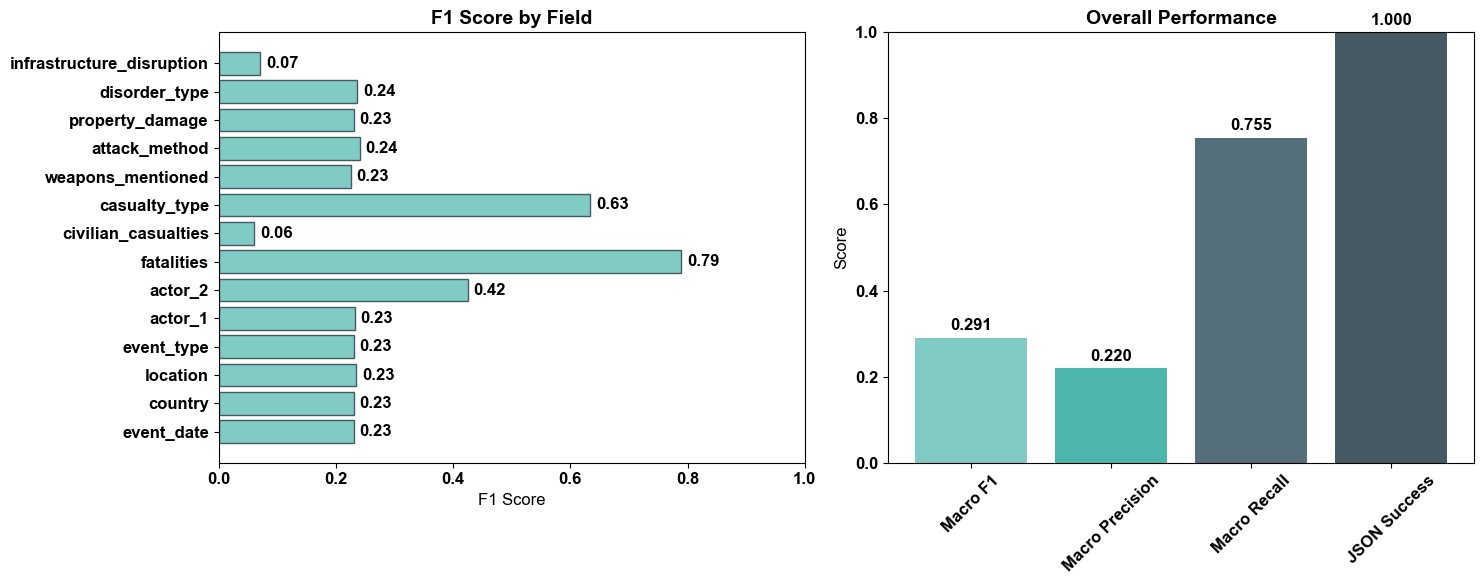

Second batch of evaluation results saved to: ACLED_llama_fine_tuned/adapters_optimised/evaluation_results_002.json


In [29]:
import matplotlib.pyplot as plt
# Font config
plt.rcParams.update({
    'font.family': 'Arial',
    'font.weight': 'bold',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14
})

print("Running Second Model Evaluation")
enhanced_results = secondary_model_evaluation(model_v, tok_v, num_samples=400)

if enhanced_results:

    colour_palette = ['#80CBC4', '#4DB6AC', '#546E7A', '#455A64']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # F1 Scores by Field
    fields = list(enhanced_results['field_metrics'].keys())
    f1_scores = [enhanced_results['field_metrics'][field]['f1_score'] for field in fields]
    
    bars = ax1.barh(fields, f1_scores, color='#80CBC4', edgecolor='#455A64')
    ax1.set_xlabel('F1 Score')
    ax1.set_title('F1 Score by Field', fontweight='bold')
    ax1.set_xlim(0, 1)
    
    for bar, score in zip(bars, f1_scores):
        ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{score:.2f}', va='center')

    # Overall Metrics
    metrics = ['Macro F1', 'Macro Precision', 'Macro Recall', 'JSON Success']
    values = [
        enhanced_results['overall_metrics']['macro_f1'],
        enhanced_results['overall_metrics']['macro_precision'],
        enhanced_results['overall_metrics']['macro_recall'],
        enhanced_results['valid_json_rate']
    ]
    
    bars = ax2.bar(metrics, values, color=colour_palette)
    ax2.set_ylabel('Score')
    ax2.set_title('Overall Performance', fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Append metadata
    enhanced_results['evaluation_metadata'] = {
        'timestamp': datetime.now().isoformat(),
        'model_info': {
            'base_model': config.MODEL_PATH,
            'adapter_path': str(adapters_dir),
            'samples_tested': 400
        }
    }
    
    enhanced_results_file = Path(adapters_dir) / "evaluation_results_002.json"
    with open(enhanced_results_file, 'w') as f:
        json.dump(enhanced_results, f, indent=2, default=str)
    
    print(f"Second batch of evaluation results saved to: {enhanced_results_file}")
else:

    print("Second evaluation failed")